In [1]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
df_no_diagnosis = pd.read_csv('demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [3]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [42]:
df

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI
...,...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN,COPD
122,223,NaN,NaN,NaN,NaN,NaN,COPD
123,224,10.00,F,NaN,32.3,143.0,Healthy
124,225,0.83,M,NaN,7.8,74.0,Healthy


In [4]:
root = 'C:/Users/home/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [5]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [6]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,224,1b2,Al,sc,Meditron
0,225,1b1,Pl,sc,Meditron
0,226,1b1,Al,sc,Meditron
0,226,1b1,Ll,sc,Meditron
0,226,1b1,Pl,sc,LittC2SE


In [7]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [8]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

,filename
0,101_1b1_Al_sc_Meditron
1,101_1b1_Pr_sc_Meditron
2,102_1b1_Ar_sc_Meditron
3,103_2b2_Ar_mc_LittC2SE
4,104_1b1_Al_sc_Litt3200
...,...
915,224_1b2_Al_sc_Meditron
916,225_1b1_Pl_sc_Meditron
917,226_1b1_Al_sc_Meditron
918,226_1b1_Ll_sc_Meditron


In [9]:
audio_path = 'C:/Users/home/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment

  0%|          | 0/920 [00:00<?, ?it/s]

In [10]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [10]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read
import IPython.display as ipd

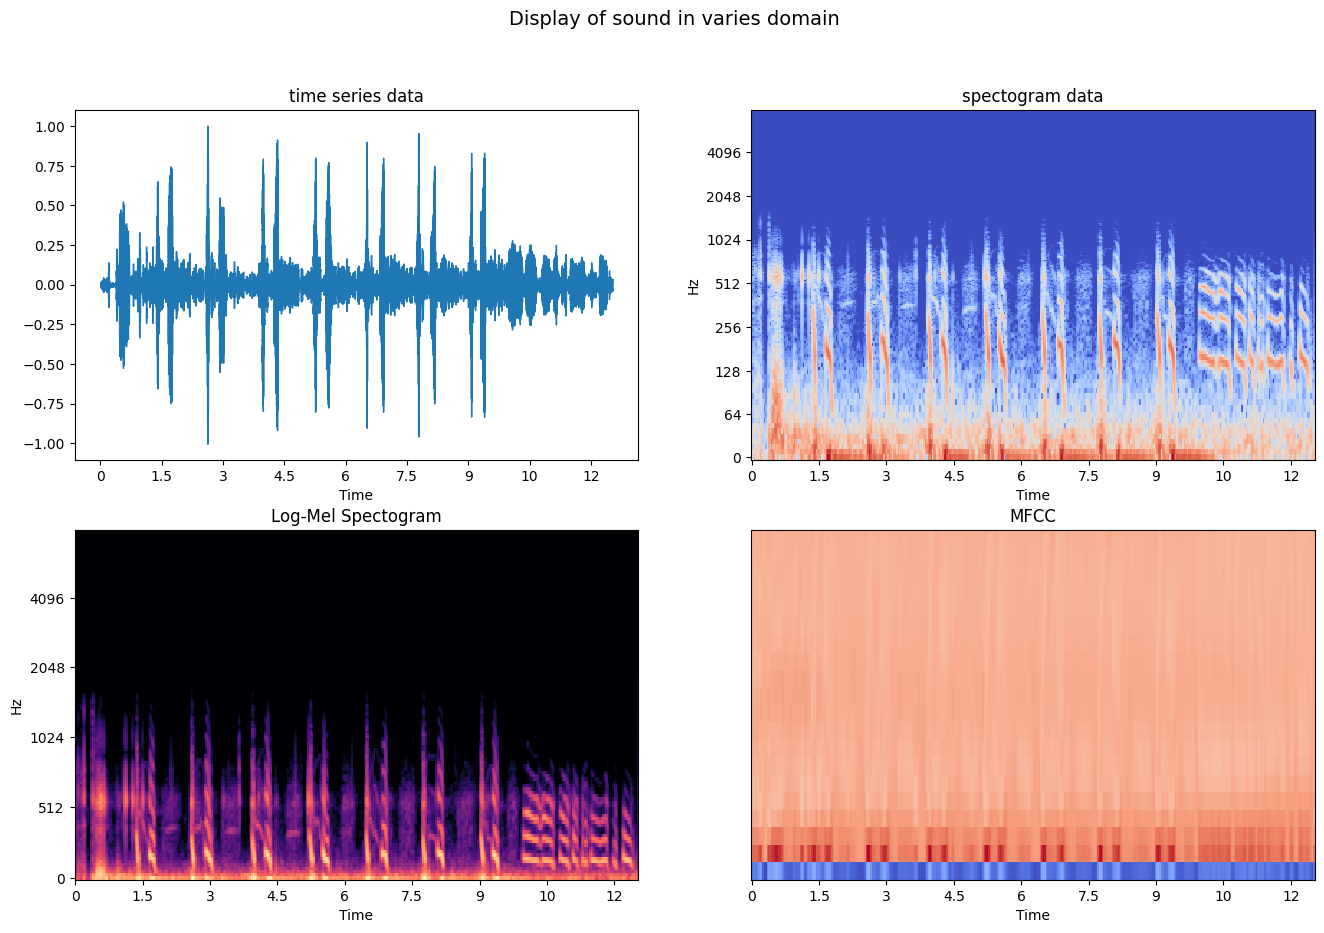

In [12]:
# Displaying sound data 
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
i = 100
sound_filename = os.path.join(audio_path, file_label_df['filename'][i] + '.wav')
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);

In [40]:
len(df[df['Diagnosis']=='Pneumonia'])

6

In [41]:
df['Diagnosis'].unique()

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [25]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [26]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)

  0%|          | 0/920 [00:00<?, ?it/s]

In [28]:
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [29]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8) 

In [30]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [13]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [14]:
labels = []
# labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
# labels_3 = np.array(labels_3)

  0%|          | 0/920 [00:00<?, ?it/s]

In [15]:
labels = []
# labels_3 = []
preprocessed_data = []
folder_path = "data/orig/0"
for filename in os.listdir(folder_path):
    labels.append([1, 0])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    data = preprocessing(audio_file, mode = 'mfcc')
    preprocessed_data.append(data)
folder_path = "data/orig/1"
for filename in os.listdir(folder_path):
    labels.append([0, 1])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    data = preprocessing(audio_file, mode = 'mfcc')
    preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)

In [16]:
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [17]:
# one hot encoding lab
oh_labels = labels

In [18]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 12
Value: 1, Count: 12


In [31]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [34]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = 8
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [35]:
num_epochs = 30
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3497 - loss: 9.4642 
Epoch 1: val_accuracy improved from -inf to 0.82432, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3724 - loss: 9.0789 - val_accuracy: 0.8243 - val_loss: 1.3151
Epoch 2/30
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8202 - loss: 1.1656
Epoch 2: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8235 - loss: 1.1262 - val_accuracy: 0.8243 - val_loss: 1.1823
Epoch 3/30
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8723 - loss: 0.7007
Epoch 3: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8722 - loss: 0.7097 - val_accuracy: 0.8108 - val_loss: 1.1883
Epoch 4/30
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8854 - loss: 0.5831
Epoch 4: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8844 - loss: 0.58

In [36]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Figure size 640x480 with 0 Axes>

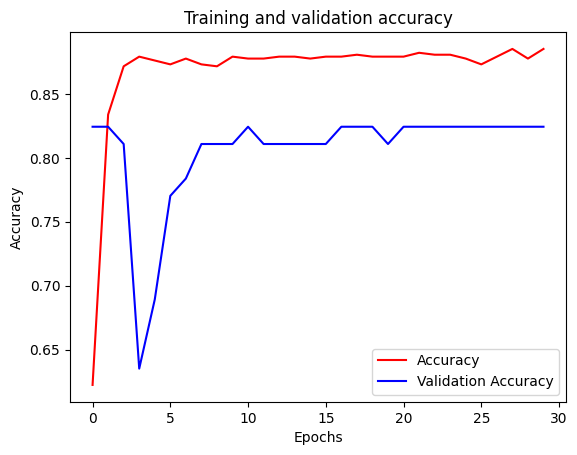

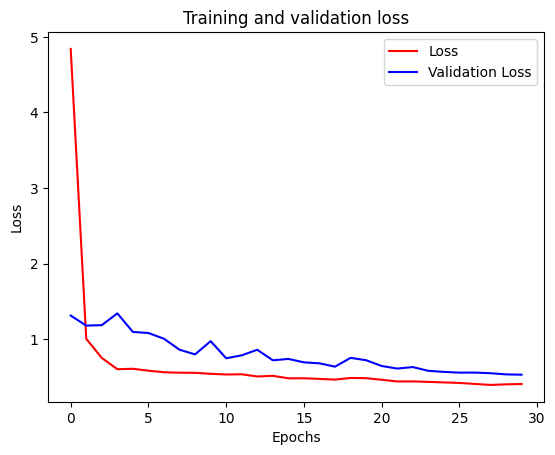

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [38]:
labels = []
# labels_3 = []
preprocessed_data = []
folder_path = "data/orig/0"
for filename in os.listdir(folder_path):
    labels.append([1, 0])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    data = preprocessing(audio_file, mode = 'mfcc')
    preprocessed_data.append(data)
folder_path = "data/orig/1"
for filename in os.listdir(folder_path):
    labels.append([0, 1])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    data = preprocessing(audio_file, mode = 'mfcc')
    preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)

In [ ]:
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8) 